In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from copy import copy
from scipy.sparse import csr_matrix

In [3]:
class SIR_model():
    '''
    This class simulates a epidemics on temporal graph using a SIR model
    
    Use: SIR_model(df).simulate(beta, mu, f)
    
    Inputs:
        * df (DataFrame): columns ('i','j','t')
        * beta (float): infection rate
        * mu (float): recovery rate
        * f (float): fraction of initial infected nodes  
        
    '''
    
    def __init__(self, df):
        
        self.df = df
        self.nodes = np.unique(df[['i','j']].values)

    def init_epi(self, f):
        '''
        Initialize the epidemics with a fraction f of nodes infected
        '''

        # initial f*len(nodes) infected nodes are sampled uniformely from node list, without replacement
        self.i0 = np.random.choice(len(self.nodes), int(f*len(self.nodes)), replace=False) 
        self.I = np.full(len(self.nodes),0)
        self.R = np.full(len(self.nodes),0)
        self.I[self.i0] = 1
        # i0 provides the indeces of nodes infected
        # I, R are vectors of length len(nodes) of 0 and 1 

    def simulate(self, beta, mu, f):
        '''
        SIR simulation with infection rate beta, recovery rate mu and initial fraction f of infected nodes
        '''


        self.init_epi(f)
       
        S_list = [len(self.nodes)-self.I.sum()]
        I_list = [self.I.sum()]
        R_list = [0]

        t_list = np.sort(self.df.t.unique())
        
        for t in np.sort(t_list):
            S = 1 - self.I - self.R
            if any(c == -1 for c in S):
                print('error')
                break

            old_susc_indeces = list(np.where(S==1)[0])
            old_inf_indeces = list(np.where(self.I==1)[0])

            old_susc = self.nodes[old_susc_indeces]
            old_inf = self.nodes[old_inf_indeces]

            for s_ind,susc in zip(old_susc_indeces, old_susc):
                neighbours = self.df[((self.df.i == susc) | (self.df.j == susc)) & (self.df.t == t)][['i','j']].values 
                neighbours = np.unique(neighbours[neighbours != susc]) # set of neighbours at t
                neighbours = neighbours[np.isin(neighbours, old_inf)] # neighbours that are infected
                p = 1 - (1-beta)**len(neighbours)
                
                if p >= np.random.uniform(0,1):
                    self.I[s_ind] = 1 # it becomes infected

            for inf_ind in old_inf_indeces:
                if mu >= np.random.uniform(0,1):
                    self.I[inf_ind]= 0
                    self.R[inf_ind]= 1

            S_list.append(len(self.nodes) - self.I.sum() - self.R.sum())
            I_list.append(self.I.sum())
            R_list.append(self.R.sum())

            if self.I.sum() == 0: # all infected have recovered
                break

            S = 1 - self.I - self.R
            if S.sum() == 0: # no more susceptibles
                print(f'all infected at t={t}')
                break
            
            l = min(len(t_list), len(S_list))
        return S_list[:l], I_list[:l], R_list[:l]








In [4]:
df = pd.read_csv('school_data/data/High-School_data_2013.csv', header = None, sep = ' ', names = ['t', 'i', 'j','c_i','c_j'])
df.t =df.t - df.t.min()

In [ ]:
m = SIR_model(df)

In [ ]:
s,i,r = m.simulate(0.01, 0.001, 0.08)

In [ ]:
plt.plot(np.sort(df.t.unique())[:len(s)], s, label='s')
plt.plot(np.sort(df.t.unique())[:len(i)], i, label='i')
plt.plot(np.sort(df.t.unique())[:len(r)], r, label='r')
plt.legend()
plt.show()

In [ ]:
df.t.hist(bins=200, grid=False)

In [ ]:
class SIR_model_V2():
    def __init__(self, df):
        
        self.df = df
        self.nodes = np.unique(df[['i','j']].values)
        node_to_index = {node: idx for idx, node in enumerate(self.nodes)}
        self.df['i_index'] = self.df['i'].map(node_to_index)
        self.df['j_index'] = self.df['j'].map(node_to_index)

    
    def initialize_state(self, f):
        '''This function initilizes the states of an SIR model setting all nodes to the susceptible state and the seeds to the infected one
        
        Use: state = initialize_state(seeds, nodes)
        
        Inputs:
            - f (float): fraction of infected nodes

        '''
        
        state = dict()
        state['S'] = set(self.nodes)
        state['I'] = set(np.random.choice(self.nodes, int(f*len(self.nodes)), replace=False))
        
        for seed in state['I']:
            state['S'].remove(seed)
        state['R'] = set()

        return state
    

    def simulate(self, beta, mu,f):
        '''This function runs a SIR model on a temporal graph
                
        Inputs: 
            - beta (float): infection rate
            - mu (float): recovery rate
            - f (float): fraction of infected nodes
            
        Output:
            - state_ev (list of dictionaries): each element corresponds to the state at a given time step
        '''
        state = self.initialize_state(f)
        
        state_ev = [state]
        t_list = np.sort(self.df.t.unique())
        
        for t in np.sort(t_list):
            sub_graph = self.df[self.df.t == t]
            
            A = csr_matrix((np.ones(len(sub_graph)), (sub_graph['i_index'], sub_graph['j_index'])), shape=(len(self.nodes), len(self.nodes)))

            state = self._update_step(state, A, beta, mu)
            state_ev.append(state)
            
            if (len(state['I'])==0) or (len(state['S'])==0): # all infected have recovered or no more susceptibles
                break

        
            

        return state_ev
    
    
    def _update_step(self, state, A, beta, mu):
        '''Perform a single step in the SEIR simulation'''

        state_ = copy(state)

        state_ = self._update_state(state_, A, mu, 'I', 'R')
        state_ = self._update_state(state_, A, beta, 'S', 'I')

        return state_


    def _update_state(self, state, A, prob, value_old, value_new):
        '''Generate the transition between two states'''

        state_ = copy(state)

        if value_old == 'S':
            idxS = np.array([i in state_['S'] for i in self.nodes])
            I = np.array([1 if i in state_['I'] else 0 for i in self.nodes])
            pinf = 1-(1-prob)**(A[idxS]@I)
            idx = np.random.binomial(1, pinf) == 1

        else:
            idx = np.random.binomial(1, prob, len(state[value_old])) == 1
        
        # nodes that will change their state from value_old to value_new
        selected_nodes = [v for i, v in enumerate(state[value_old]) if idx[i]]

        # update
        state_[value_new] = state_[value_new].union(selected_nodes)
        state_[value_old] = state_[value_old].difference(selected_nodes)

        return state_



        

In [59]:
m = SIR_model_V2(df)

In [70]:
d = m.simulate(0.1, 0.01, 0.5)

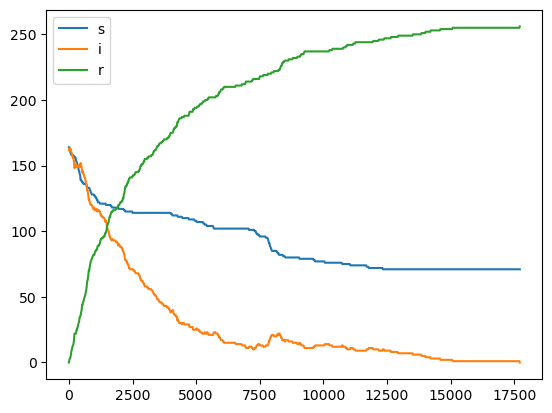

In [71]:
plt.plot(np.sort(df.t.unique())[:min(len(df.t.unique()),len(d))], [len(x['S']) for x in d][:min(len(df.t.unique()),len(d))], label='s')
plt.plot(np.sort(df.t.unique())[:min(len(df.t.unique()),len(d))], [len(x['I']) for x in d][:min(len(df.t.unique()),len(d))], label='i')
plt.plot(np.sort(df.t.unique())[:min(len(df.t.unique()),len(d))], [len(x['R']) for x in d][:min(len(df.t.unique()),len(d))], label='r')
plt.legend()
plt.show()

In [54]:
m = SIR_model(df)
s,i,r = m.simulate(0.1, 0.01, 0.5)

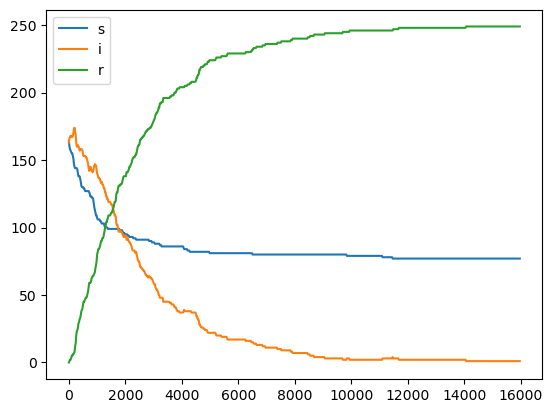

In [55]:
plt.plot(np.sort(df.t.unique())[:len(s)], s, label='s')
plt.plot(np.sort(df.t.unique())[:len(i)], i, label='i')
plt.plot(np.sort(df.t.unique())[:len(r)], r, label='r')
plt.legend()
plt.show()